# Comparing findings from all three FBI datasets

This notebook compares data and findings from the three main FBI data sources previously examined: "Return A", the Supplementary Homicide Report, and the National Incident-Based Reporting System. Please see this repository's `README.md` file for more context.

# Import Python libraries

In [1]:
# Data analysis
import pandas as pd

# Charting
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
%matplotlib inline

from utils import (
    percentify_axes,
    plot_rates,
    load_reta_metadata_2016,
    load_reta_annual_counts,
    load_shr_metadata_2016,
    load_shr_murder_victims,
    load_nibrs_metadata_2016,
    load_nibrs_victims,
)

# Load the three datasets and an agency-identifier crosswalk

### Return A

In [2]:
reta_metadata = load_reta_metadata_2016()

reta_metadata.head()

,year,agency_ori_7,agency_name,ori_group,pop1,pop2,pop3,larger_city
936209,2016,VI00103,ST. CROIX,0,0,0,0,False
921171,2016,ME00201,CARIBOU,6,7747,0,0,False
921107,2016,LA05304,AMITE,6,4421,0,0,False
921108,2016,LA05305,INDEPENDENCE,7,1820,0,0,False
921109,2016,LA05306,ROSELAND,7,1219,0,0,False


In [3]:
reta_annual_counts = (
    load_reta_annual_counts()
    .assign(
        # Note: pd.np.where operates as a vectorized if/else statement
        top_offense_code = lambda df: pd.np.where(
            df["offense"] == "assault_simple",
            "13B",
            pd.np.where(
                df["offense"] == "murder",
                "09A",
                "13A"
            )
        )
    )
)

reta_annual_counts.head()

,agency_ori_7,year,offense,actual,cleared,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,top_offense_code
8,AK00101,1965,assault_gun,28,19,4,False,1C,True,13A
9,AK00101,1965,murder,7,6,4,False,1C,True,09A
10,AK00101,1966,assault_gun,22,17,3,False,1C,True,13A
11,AK00101,1966,murder,18,16,3,False,1C,True,09A
12,AK00101,1967,assault_gun,24,21,3,False,1C,True,13A


### NIBRS

In [4]:
nibrs_metadata = load_nibrs_metadata_2016()

nibrs_metadata.head()

,agency_ori_9,year,ori_group,pop1,pop2,pop3,pop4,pop5,num_months,larger_city
266165,NC0050100,2016,7,1309,0,0,0,0,0,False
194098,MD0060000,2016,8C,21836,0,0,0,0,0,False
193890,MD0040700,2016,7,0,0,0,0,0,0,False
193916,MD0040800,2016,7,0,0,0,0,0,0,False
193942,MD0040900,2016,7,0,0,0,0,0,0,False


In [5]:
nibrs_victims = load_nibrs_victims()

nibrs_victims.head()

,victim_uid,top_offense_code,incident_uid,victim_injury_category,domestic_violence_ind,family_violence_ind,victim_age,victim_sex,victim_race,victim_ethnicity,...,arrest_date,exc_clearance_ind,exc_clearance_date,clearance_ind,victim_count,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,state
0,VA0370000|1996|Z63BRW5HPU72-001,09A,VA0370000|1996|Z63BRW5HPU72,major,0,1,48,F,B,N,...,1996-06-21,0,NaN,1,3,9C,False,9C,False,VA
1,VA1230000|2015|94-4NLE8O39G-001,09A,VA1230000|2015|94-4NLE8O39G,missing,0,0,21,M,B,N,...,NaT,0,NaN,0,3,3,False,3,False,VA
2,OHCOP0000|2010|8I0VYC5VT2 N-001,09A,OHCOP0000|2010|8I0VYC5VT2 N,missing,0,0,15,M,B,NaN,...,NaT,0,NaN,0,1,1B,True,1B,True,OH
3,CT0004300|2012|2W1J0U73LNK-001,09A,CT0004300|2012|2W1J0U73LNK,major,1,0,28,F,W,N,...,2012-05-19,0,NaN,1,2,3,False,3,False,CT
4,VA1230000|2015|7I-IMIR6ZU72-001,09A,VA1230000|2015|7I-IMIR6ZU72,missing,0,0,24,M,B,N,...,2015-05-18,0,NaN,1,4,3,False,3,False,VA


In [6]:
nibrs_early_nonupdaters = (
    nibrs_victims
    .loc[lambda df: df["year"] >= 2000]
    .loc[lambda df: df["larger_city_2016"] == True]
    .assign(
        days_to_arrest = lambda df: (df["arrest_date"] - df["occurred_date"]).dt.days
    )
    .groupby([ "agency_ori_9" ])
    .pipe(lambda grp: pd.DataFrame({
        "days_to_arrest_max": grp["days_to_arrest"].max(),
        "num_incidents": grp.size()
    }))
    .loc[lambda df: df["days_to_arrest_max"] <= 100]
    .sort_values("days_to_arrest_max")
)

nibrs_early_nonupdaters

,days_to_arrest_max,num_incidents
agency_ori_9,,
WA0320400,17.0,445
TX2200100,33.0,28
MA0091100,50.0,4037
OK0140200,87.0,400


### SHR

In [7]:
shr_metadata = load_shr_metadata_2016()

shr_metadata.head()

,agency_ori_7,year,ori_group,pop1,larger_city
109838,VI00103,2016,0,0,False
107807,ME00600,2016,8B,50327,False
107816,MD00100,2016,9D,2220,False
107815,MDBPD00,2016,1B,618385,True
107814,ME01601,2016,5,21285,False


In [8]:
shr_victims = load_shr_murder_victims()

shr_victims.head()

,incident_uid,year,agency_ori_7,offender_age_reported,firearm_ind,domestic_violence_ind,family_violence_ind,month,top_offense_code,victim_uid,victim_age,victim_ethnicity,victim_race,victim_sex,circumstance_main,state,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016
0,SC04200|17|10|001,2017,SC04200,1,1,0,0,10,09A,SC04200|17|10|001-1,34,NaN,W,F,Other arguments,SC,9A,False,9A,False
1,SC00201|17|05|001,2017,SC00201,1,1,0,0,5,09A,SC00201|17|05|001-1,19,NaN,B,M,Circumstances undetermined,SC,4,False,4,False
2,RI00409|17|06|002,2017,RI00409,0,1,0,0,6,09A,RI00409|17|06|002-1,36,NaN,U,M,Other arguments,RI,2,True,2,True
3,RI00409|17|07|001,2017,RI00409,1,1,0,0,7,09A,RI00409|17|07|001-1,22,NaN,B,M,Circumstances undetermined,RI,2,True,2,True
4,RI00409|17|07|002,2017,RI00409,0,1,0,0,7,09A,RI00409|17|07|002-1,34,NaN,B,M,Other arguments,RI,2,True,2,True


### Identifier crosswalk

The Return A and SHR datasets use the FBI's seven-digit "Originating Agency Identification" (ORI) codes to identify police departments and other law enforcement agencies, while the NIBRS dataset uses the FBI's nine-digit ORI codes. To be able to compare the datasets, we use the Bureau of Justice Statistics' "[Law Enforcement Agency Identifiers Crosswalk](https://www.icpsr.umich.edu/icpsrweb/NACJD/studies/35158)", which includes both the seven- and nine-digit ORI codes for each agency.

In [9]:
crosswalk = (
    pd.read_csv(
        "../../data/identifier-crosswalk/raw/35158-0001-Data.tsv",
        sep = "\t",
        usecols = [
            "NAME",
            "ADDRESS_CITY",
            "ADDRESS_STATE",
            "ORI9",
            "ORI7"
        ],
        na_values = [ "-1" ]
    )
    .rename(columns = {
        "ORI7": "agency_ori_7",
        "ORI9": "agency_ori_9",
        "NAME": "agency_name",
        "ADDRESS_STATE": "state",
        "ADDRESS_CITY": "city",
    })
)

crosswalk.head()

,agency_ori_9,agency_ori_7,agency_name,city,state
0,AL0040200,AL00402,AUTAUGAVILLE POLICE DEPARTMENT,AUTAUGAVILLE,AL
1,AL0040100,AL00401,PRATTVILLE POLICE DEPARTMENT,PRATTVILLE,AL
2,AL0040300,NaN,PRATTVILLE FIRE DEPT ARSON INVESTIGATION BRANCH,PRATTVILLE,AL
3,AL0040000,AL00400,AUTAUGA COUNTY SHERIFF'S OFFICE,PRATTVILLE,AL
4,AL0051100,AL00511,FAULKNER STATE COMMUNITY COLLEGE POLICE DEPT,BAY MINETTE,AL


Some agencies in the Return A, NIBRS, and SHR data are not present in the identifier crosswalk, but none of those agencies are in the larger-city ORI groups (1A, 1B, 1C, 2) that are the focus of our analysis:

In [10]:
(
    pd.concat([
        reta_metadata.assign(source = "reta"),
        shr_metadata.assign(source = "shr"),
        nibrs_metadata.assign(source = "nibrs"),
    ], sort = False)
    .loc[lambda df: ~(
        (df["agency_ori_7"].notnull() & df["agency_ori_7"].isin(crosswalk["agency_ori_7"])) |
        (df["agency_ori_9"].notnull() & df["agency_ori_9"].isin(crosswalk["agency_ori_9"]))
    )]
    .groupby([ "ori_group", "source" ])
    .size()
    .sort_index()
    .to_frame("Missing Agencies")
    .unstack()
    .fillna(0)
    .astype(int)
)

Missing Agencies         
source               nibrs reta shr
ori_group                          
0                        5    6   3
3                        3    4   3
4                        4    6   4
5                       13   16   3
6                       11   71   7
7                      141  735   5
8A                       0    1   1
8B                       0    6   1
8C                       1    8   0
8D                      16  140   1
8E                      12   17   0
9A                       1    1   1
9B                       0    2   0
9D                      22  125   0
9E                      32   34   0

# Compare/combine agency metadata

In [11]:
agency_metadata_combined = (
    pd.concat([
        (
            pd.concat([
                reta_metadata.assign(source = "reta"),
                shr_metadata.assign(source = "shr"),
            ], sort = False)
            .merge(
                crosswalk
                [[
                    "agency_ori_7",
                    "agency_ori_9"
                ]],
                how = "left",
                on = [ "agency_ori_7" ]
            )
        ),
        (
            nibrs_metadata.assign(source = "nibrs")
            .merge(
                crosswalk
                [[
                    "agency_ori_7",
                    "agency_ori_9"
                ]],
                how = "left",
                on = [ "agency_ori_9" ]
            )
        )
    ], sort = False)
    [[
        "source",
        "year",
        "agency_ori_9",
        "agency_ori_7",
        "ori_group"
    ]]
)

agency_metadata_combined.head()

,source,year,agency_ori_9,agency_ori_7,ori_group
0,reta,2016,NaN,VI00103,0
1,reta,2016,ME0020100,ME00201,6
2,reta,2016,LA0530400,LA05304,6
3,reta,2016,LA0530500,LA05305,7
4,reta,2016,NaN,LA05306,7


None of the three datasets disagree with one another regarding the ORI group for each agency-year:

In [12]:
(
    agency_metadata_combined
    .groupby([
        "year",
        "agency_ori_9",
        "source"
    ])
    ["ori_group"]
    .nunique()
    .value_counts()
)

1    56930
0        1
Name: ori_group, dtype: int64

... so we can consolidate the metadata into a single, deduplicated table:

In [13]:
agency_ori_groups = (
    agency_metadata_combined
    .dropna(subset = [ "ori_group" ])
    [[
        "year",
        "agency_ori_9",
        "agency_ori_7",
        "ori_group"
    ]]
    .sort_values("year", ascending = False)
    .drop_duplicates(subset = [ "agency_ori_9", "agency_ori_7" ])
    .sort_values([ "agency_ori_9", "agency_ori_7" ])
    .rename(columns = {
        "year": "year_latest"
    })
    .assign(
        larger_city = lambda x: x["ori_group"].isin([
            "1A",
            "1B",
            "1C",
            "2"
        ])
    )
)

agency_ori_groups.head()

,year_latest,agency_ori_9,agency_ori_7,ori_group,larger_city
22154,2016,AK0010100,AK00101,1C,True
22042,2016,AK0010200,AK00102,4,False
21992,2016,AK0010300,AK00103,4,False
22013,2016,AK0010400,AK00104,6,False
22206,2016,AK0010500,AK00105,6,False


There are some agencies with no ORI9, but none are larger-city agencies:

In [14]:
(
    agency_ori_groups
    .loc[lambda df: df["agency_ori_9"].isnull()]
    .groupby([
        "ori_group"
    ])
    .size()
    .to_frame("ORI9 Null Count")
)

,ORI9 Null Count
ori_group,
0,6
3,4
4,6
5,16
6,71
7,736
8A,1
8B,6
8C,8


In [15]:
agency_ori_groups.to_csv("../../outputs/agency-ori-groups.csv", index = False)

# Compare annual victim counts and clearance-type rates

Below, we count the number victims/offenses and clearance rate, by offense type, agency, and year. For SHR, which does not have a clearance indicator, the rate refers to offender-age-reported.

In [16]:
reta_annual_counts_for_comparison = (
    reta_annual_counts
    .loc[lambda df: df["offense"].isin([
        "murder",
        "assault_gun",
        "assault_nongun"
    ])]
    
    .groupby([
        "agency_ori_7",
        "year",
        "top_offense_code",
    ])
    
    .pipe(lambda grp: pd.DataFrame({
        "reta_offenses": grp["actual"].sum(),
        "reta_clearances": grp["cleared"].sum()
    }))
    
    .reset_index()
    
    .merge(
        crosswalk
        [[
            "agency_ori_7",
            "agency_ori_9"
        ]],
        how = "left",
        on = [ "agency_ori_7" ]
    )    
)

reta_annual_counts_for_comparison.head()

,agency_ori_7,year,top_offense_code,reta_offenses,reta_clearances,agency_ori_9
0,AK00101,1965,09A,7,6,AK0010100
1,AK00101,1965,13A,66,35,AK0010100
2,AK00101,1966,09A,18,16,AK0010100
3,AK00101,1966,13A,59,36,AK0010100
4,AK00101,1967,09A,1,1,AK0010100


In [17]:
shr_annual_counts = (
    shr_victims
    .groupby([
        "agency_ori_7",
        "year",
        "top_offense_code",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "shr_offenses": grp.size(),
        "shr_offender_age_reported": grp["offender_age_reported"].sum()
    }))
    .reset_index()
    .merge(
        crosswalk
        [[
            "agency_ori_7",
            "agency_ori_9"
        ]],
        how = "left",
        on = [ "agency_ori_7" ]
    )
)

shr_annual_counts.head()

,agency_ori_7,year,top_offense_code,shr_offenses,shr_offender_age_reported,agency_ori_9
0,AK00101,1980,09A,17,12,AK0010100
1,AK00101,1981,09A,17,14,AK0010100
2,AK00101,1982,09A,22,10,AK0010100
3,AK00101,1983,09A,16,12,AK0010100
4,AK00101,1984,09A,16,14,AK0010100


In [18]:
nibrs_annual_counts = (
    nibrs_victims
    .groupby([
        "agency_ori_9",
        "year",
        "top_offense_code",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "nibrs_offenses": grp.size(),
        "nibrs_cleared": grp["clearance_ind"].sum()
    }))
    .reset_index()
    .merge(
        crosswalk
        [[
            "agency_ori_7",
            "agency_ori_9"
        ]],
        how = "left",
        on = [ "agency_ori_9" ]
    )
)

nibrs_annual_counts.head()

,agency_ori_9,year,top_offense_code,nibrs_offenses,nibrs_cleared,agency_ori_7
0,AL0010000,1991,09A,16,2,AL00100
1,AL0010000,1991,11A,53,9,AL00100
2,AL0010000,1991,11B,13,4,AL00100
3,AL0010000,1991,120,125,7,AL00100
4,AL0010000,1991,13A,754,93,AL00100


# Classify agencies by the presence of 1+ murder, for each dataset

In [19]:
reta_presence = (
    reta_annual_counts_for_comparison
    .loc[lambda df: df["top_offense_code"] == "09A"]    
    .loc[lambda df: df["reta_offenses"] > 0]
    .groupby([
        "year",
        "agency_ori_9"
    ])
    .size()
    .to_frame("rows")
    .reset_index()
    .drop(columns = [ "rows"])
    .assign(
        in_reta = True
    )
)

reta_presence.head()

,year,agency_ori_9,in_reta
0,1965,AK0010100,True
1,1965,AK0010500,True
2,1965,AKASP0000,True
3,1965,AL0010000,True
4,1965,AL0010100,True


In [20]:
nibrs_presence = (
    nibrs_annual_counts
    .loc[lambda df: df["top_offense_code"] == "09A"]
    .loc[lambda df: df["nibrs_offenses"] > 0]
    .groupby([
        "year",
        "agency_ori_9"
    ])
    .size()
    .to_frame("rows")
    .reset_index()
    .drop(columns = [ "rows"])
    .assign(
        in_nibrs = True
    )
)

nibrs_presence.head()

,year,agency_ori_9,in_nibrs
0,1991,AL0010000,True
1,1991,AL0010100,True
2,1991,AL0010200,True
3,1991,AL0010400,True
4,1991,AL0010700,True


In [21]:
shr_presence = (
    shr_annual_counts
    .loc[lambda df: df["top_offense_code"] == "09A"]    
    .loc[lambda df: df["shr_offenses"] > 0]
    .groupby([
        "year",
        "agency_ori_9"
    ])
    .size()
    .to_frame("rows")
    .reset_index()
    .drop(columns = [ "rows"])
    .assign(
        in_shr = True
    )
)

shr_presence.head()

,year,agency_ori_9,in_shr
0,1980,AK0010100,True
1,1980,AK0010300,True
2,1980,AK0010600,True
3,1980,AK0011300,True
4,1980,AK0011800,True


In [22]:
murder_reporting_years = (
    reta_annual_counts_for_comparison
    [[
        "year",
        "agency_ori_9"
    ]]
    .drop_duplicates()
    .merge(
        agency_ori_groups
        [[
            "agency_ori_9",
            "ori_group",
            "larger_city",
        ]]
        .dropna(),
        how = "left",
        on = [ "agency_ori_9" ],
        validate = "many_to_one"
    )
    .merge(
        reta_presence,
        how = "left",
        validate = "1:1",
    )
    .merge(
        shr_presence,
        how = "outer",
        validate = "many_to_many",
    )
    .merge(
        nibrs_presence,
        how = "outer",
        validate = "many_to_many",
    )
    .assign(
        in_reta = lambda df: df["in_reta"].fillna(False),
        in_shr = lambda df: df["in_shr"].fillna(False),
        in_nibrs = lambda df: pd.np.where(
            # 2016 is the most recent year of full NIBRS data available
            df["year"] == 2017,
            df["in_nibrs"],
            df["in_nibrs"].fillna(False)
        ),
    )
)

murder_reporting_years.head()

,year,agency_ori_9,ori_group,larger_city,in_reta,in_shr,in_nibrs
0,1965,AK0010100,1C,True,True,False,False
1,1966,AK0010100,1C,True,True,False,False
2,1967,AK0010100,1C,True,True,False,False
3,1968,AK0010100,1C,True,True,False,False
4,1969,AK0010100,1C,True,True,False,False


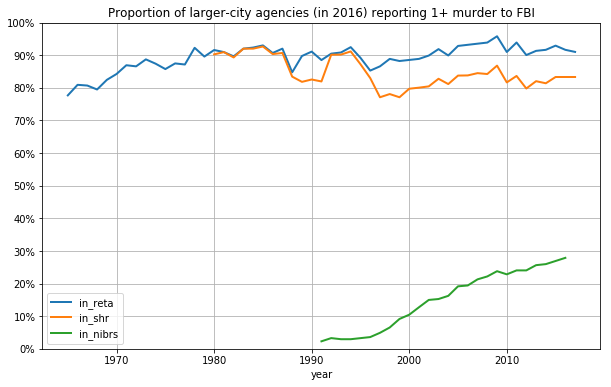

In [23]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    murder_reporting_years
    .loc[lambda df: df["larger_city"] == True]
    .fillna(False)
    .groupby([
        "year"
    ])
    [[
        "in_reta",
        "in_shr",
        "in_nibrs",
    ]]
    .mean()
    .replace(0, pd.np.nan)
    .plot(
        ax = ax,
        lw = 2,
        title = "Proportion of larger-city agencies (in 2016) reporting 1+ murder to FBI"
    )
)

percentify_axes(ax)
ax.grid()
pass

The gap in RETA vs. SHR reporting is almost entirely due to a few states:

In [24]:
(    
    murder_reporting_years
    .loc[lambda df: df["year"] >= 1980]
    .loc[lambda df: df["larger_city"] == True]
    .loc[lambda df: df["in_reta"] == True]
    .loc[lambda df: df["in_shr"] == False]
    .assign(state = lambda df: df["agency_ori_9"].str.slice(0, 2))
    ["state"]
    .value_counts()
)

FL    496
IL    111
AL     35
KS     21
NB     16
DC     13
CO     10
TN      7
MT      3
WI      3
NY      3
TX      2
IA      2
MI      2
OR      2
MA      1
MN      1
OH      1
CT      1
NM      1
LA      1
PA      1
Name: state, dtype: int64

# Compare clearance/offender-reported rates between datasets

### RETA vs. NIBRS

In [25]:
reta_vs_nibrs_by_agency = (
    murder_reporting_years
    .loc[lambda df: df["in_reta"] == True]
    .loc[lambda df: df["in_nibrs"] == True]
    .loc[lambda df: df["larger_city"] == True]
    [[
        "year",
        "agency_ori_9"
    ]]
    .merge(
        (
            reta_annual_counts_for_comparison
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "reta_offenses",
                "clearances": "reta_clearances",
            })
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
    .merge(
        (
            nibrs_annual_counts
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "nibrs_offenses",
                "cleared": "nibrs_cleared",
            }) 
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
)

reta_vs_nibrs_by_agency.head()

,year,agency_ori_9,reta_offenses,reta_clearances,nibrs_offenses,nibrs_cleared
0,1991,AL0010200,139,105,142,13
1,1992,AL0010200,133,86,81,10
2,1991,AL0020100,40,41,40,4
3,1992,AL0020100,35,29,16,3
4,1991,AL0030100,36,22,36,0


Including all larger-city agencies that reported to both:

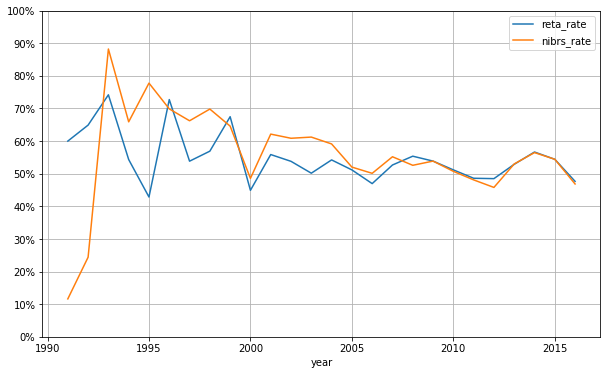

In [26]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_nibrs_by_agency
    .groupby("year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "nibrs_rate": grp["nibrs_cleared"].sum() / grp["nibrs_offenses"].sum(),
    }))
    .plot(ax = ax)
)
percentify_axes(ax)
ax.grid()
pass

Excluding agencies with zero reported clearances:

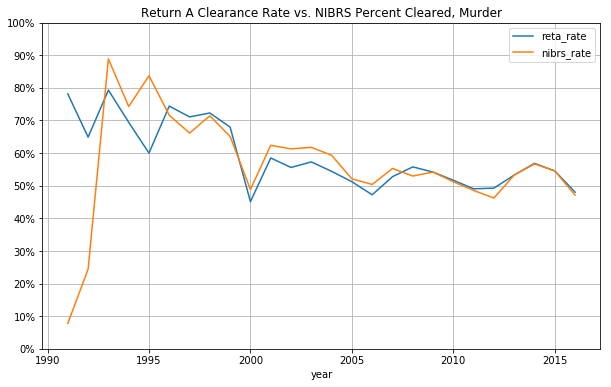

In [27]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_nibrs_by_agency
    .loc[lambda df: df["reta_clearances"] > 0]
    .groupby("year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "nibrs_rate": grp["nibrs_cleared"].sum() / grp["nibrs_offenses"].sum(),
    }))
    .plot(
        ax = ax,
        title = "Return A Clearance Rate vs. NIBRS Percent Cleared, Murder"
    )
)
percentify_axes(ax)
ax.grid()
pass

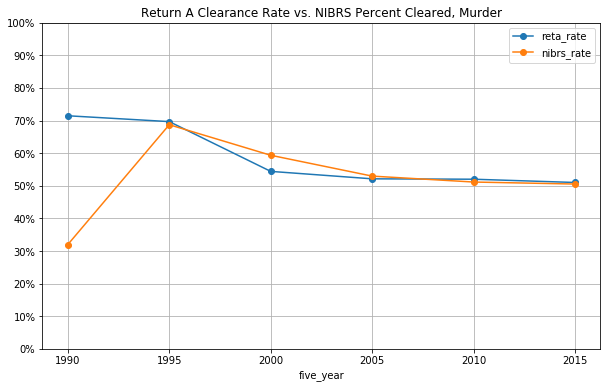

In [28]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_nibrs_by_agency
    .loc[lambda df: df["reta_clearances"] > 0]
    .assign(
        five_year = lambda df: (df["year"] // 5) * 5
    )
    .groupby("five_year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "nibrs_rate": grp["nibrs_cleared"].sum() / grp["nibrs_offenses"].sum(),
    }))
    .plot(
        ax = ax,
        marker = "o",
        title = "Return A Clearance Rate vs. NIBRS Percent Cleared, Murder"
    )
)
percentify_axes(ax)
ax.grid()
pass

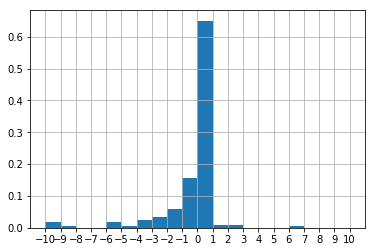

In [29]:
ax = (
    reta_vs_nibrs_by_agency
    .loc[lambda df: df["year"] >= 2000]
    .loc[lambda df: df["year"] < 2005]
    .loc[lambda df: (df["reta_offenses"] - df["nibrs_offenses"]).abs() <= 5]
    .assign(diff = lambda df: (df["reta_clearances"] - df["nibrs_cleared"]))
    .sort_values("diff", ascending = False)
    ["diff"]
    .clip(-10, 10)
    .hist(bins = range(-10, 11), density = True)
)

ax.set_xticks(range(-10, 11))
pass

### RETA vs. SHR

In [30]:
reta_vs_shr_by_agency = (
    murder_reporting_years
    .loc[lambda df: df["in_reta"] == True]
    .loc[lambda df: df["in_shr"] == True]
    .loc[lambda df: df["larger_city"] == True]
    [[
        "year",
        "agency_ori_9"
    ]]
    .merge(
        (
            reta_annual_counts_for_comparison
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "reta_offenses",
                "clearances": "reta_clearances",
            })
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
    .merge(
        (
            shr_annual_counts
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "shr_offenses",
                "offender_age_reported": "shr_offender_age_reported",
            }) 
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
)

reta_vs_shr_by_agency.head()

,year,agency_ori_9,reta_offenses,reta_clearances,shr_offenses,shr_offender_age_reported
0,1980,AK0010100,15,8,17,12
1,1981,AK0010100,18,13,17,14
2,1982,AK0010100,22,11,22,10
3,1983,AK0010100,16,12,16,12
4,1984,AK0010100,16,14,16,14


Including all larger-city agencies that reported to both:

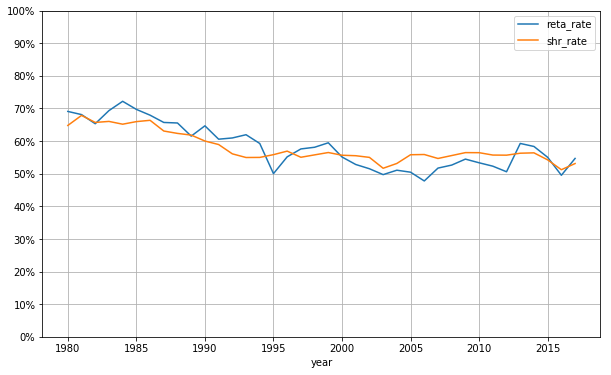

In [31]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_shr_by_agency
    .groupby("year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
    }))
    .plot(ax = ax)
)
percentify_axes(ax)
ax.grid()
pass

Excluding agencies with zero reported clearances:

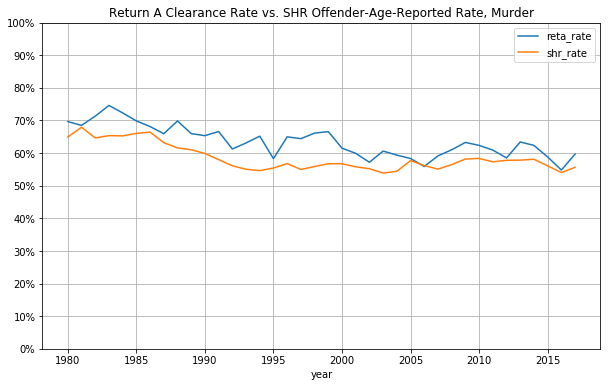

In [32]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_shr_by_agency
    .loc[lambda df: df["reta_clearances"] > 0]    
    .loc[lambda df: df["shr_offender_age_reported"] > 0]    
    .groupby("year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
    }))
    .plot(
        ax = ax,
        title = "Return A Clearance Rate vs. SHR Offender-Age-Reported Rate, Murder"        
    )
)
percentify_axes(ax)
ax.grid()
pass

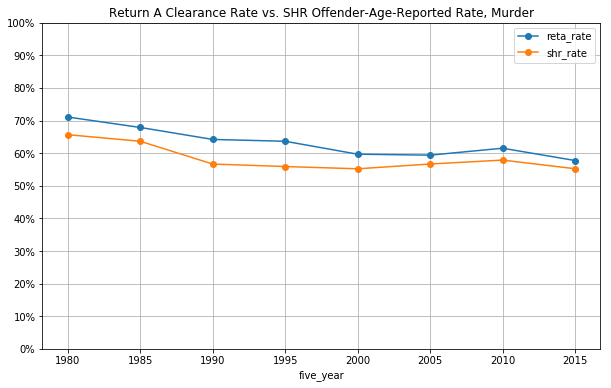

In [33]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    reta_vs_shr_by_agency
    .assign(
        five_year = lambda df: (df["year"] // 5) * 5
    )    
    .loc[lambda df: df["reta_clearances"] > 0]
    .loc[lambda df: df["shr_offender_age_reported"] > 0]        
    .groupby("five_year")
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
    }))
    .plot(
        ax = ax,
        title = "Return A Clearance Rate vs. SHR Offender-Age-Reported Rate, Murder",
        marker = "o"
    )
)
percentify_axes(ax)
ax.grid()
pass

# RETA vs. SHR, by NIBRS participation

As NIBRS participation increases, so too has the proportion of murders in SHR that were submitted by NIBRS agencies.  (When an agency submits NIBRS data, its SHR data is automatically created from it.)

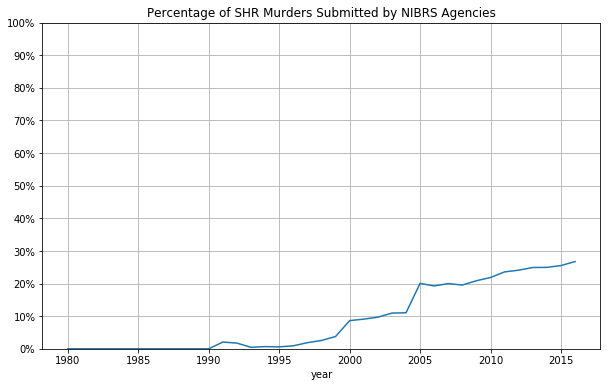

In [34]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    shr_annual_counts
    .dropna(subset = [ "agency_ori_9" ])
    .merge(
        murder_reporting_years
        [[ "year", "agency_ori_9", "in_nibrs", "larger_city" ]],
        how = "left",
        validate = "1:1"
    )
    .loc[lambda df: df["larger_city"] == True]
    .loc[lambda df: df["year"] < 2017]
    .assign(in_nibrs = lambda df: df["in_nibrs"].astype(int))
    .groupby([
        "year",
        "in_nibrs"
    ])
    ["shr_offenses"]
    .sum()
    .unstack()
    .fillna(0)
    .assign(
        prop = lambda df: df[1] / (df.sum(axis = 1))
    )
    ["prop"]
    .plot(
        title = "Percentage of SHR Murders Submitted by NIBRS Agencies"
    )
)

percentify_axes(ax)
ax.grid()
pass

In [35]:
nibrs_oris = (
    murder_reporting_years
    .loc[lambda df: df["in_nibrs"] == True]
    ["agency_ori_9"]
    .unique()
)

len(nibrs_oris)

3945

Comparing SHR offender-age-reported vs. Return A clearance rates, by NIBRS participation (ever):

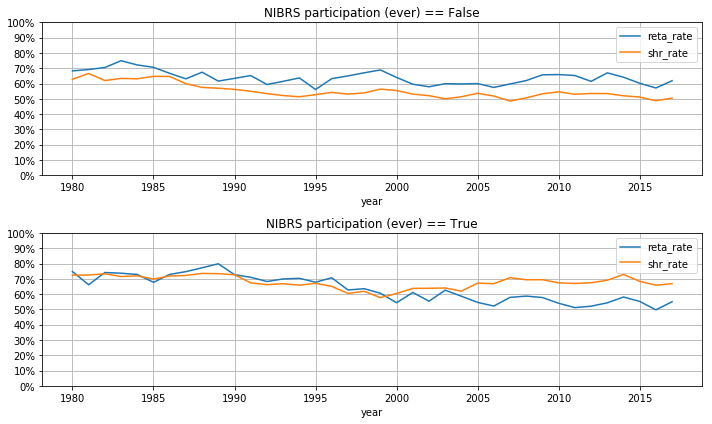

In [36]:
fig, axs = plt.subplots(figsize = (10, 6), nrows = 2)

for nibrs_int in [ 0, 1 ]:
    (
        reta_vs_shr_by_agency
        .loc[lambda df: df["agency_ori_9"].isin(nibrs_oris) == nibrs_int]
        .loc[lambda df: df["reta_clearances"] > 0]    
        .groupby("year")
        .pipe(lambda grp: pd.DataFrame({
            "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
            "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
        }))
        .plot(
            ax = axs[nibrs_int],
            title = f"NIBRS participation (ever) == {bool(nibrs_int)}"
        )
    )
    percentify_axes(axs[nibrs_int])
    axs[nibrs_int].grid()
    
fig.tight_layout()

pass

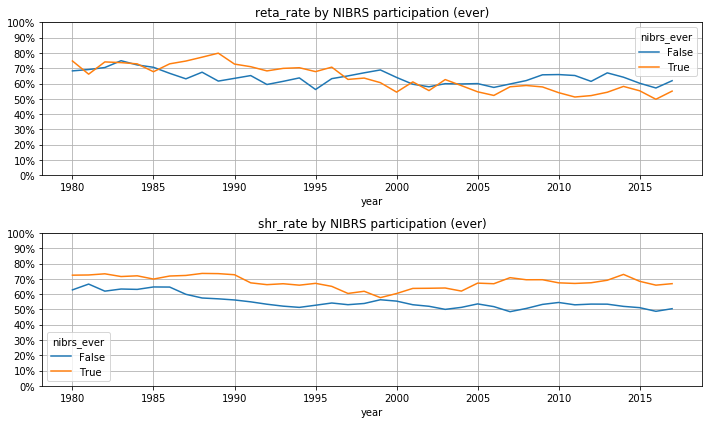

In [37]:
fig, axs = plt.subplots(figsize = (10, 6), nrows = 2)

for i, rate in enumerate([ "reta_rate", "shr_rate" ]):
    (
        reta_vs_shr_by_agency
        .assign(
            nibrs_ever = lambda df: df["agency_ori_9"].isin(nibrs_oris)
        )
        .loc[lambda df: df["reta_clearances"] > 0]    
        .groupby([
            "year",
            "nibrs_ever",
        ])
        .pipe(lambda grp: pd.DataFrame({
            "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
            "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
        }))
        [rate]
        .unstack()
        .plot(
            ax = axs[i],
            title = f"{rate} by NIBRS participation (ever)"
        )
    )
    percentify_axes(axs[i])
    axs[i].grid()
    
fig.tight_layout()
pass

Among NIBRS participants (ever), by NIBRS participation for the particular year:

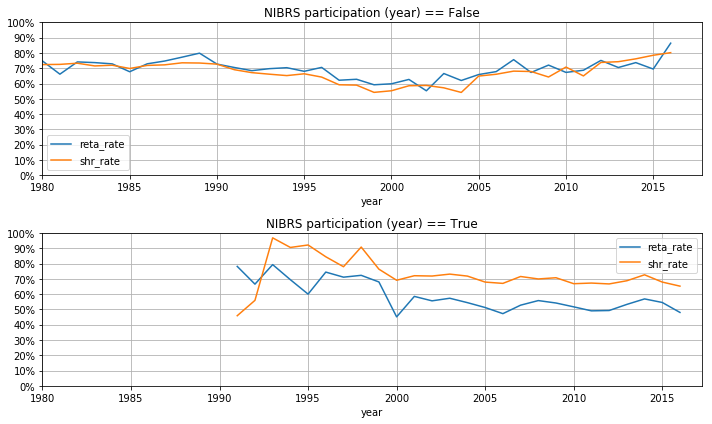

In [38]:
fig, axs = plt.subplots(figsize = (10, 6), nrows = 2)

for nibrs_int in [ 0, 1 ]:
    (
        reta_vs_shr_by_agency
        .merge(
            murder_reporting_years,
            how = "left"
        )
        .loc[lambda df: df["agency_ori_9"].isin(nibrs_oris) == True]
        .loc[lambda df: df["in_nibrs"] == nibrs_int]
        .loc[lambda df: df["reta_clearances"] > 0]    
        .groupby("year")
        .pipe(lambda grp: pd.DataFrame({
            "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
            "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
        }))
        .plot(
            ax = axs[nibrs_int],
            title = f"NIBRS participation (year) == {bool(nibrs_int)}",
            xlim = (1980, None)
        )
    )
    percentify_axes(axs[nibrs_int])
    axs[nibrs_int].grid()
    
fig.tight_layout()
pass

In [39]:
(
    reta_vs_shr_by_agency
    .merge(
        murder_reporting_years,
        how = "left"
    )
    .loc[lambda df: df["reta_clearances"] > 0]    
    .loc[lambda df: df["shr_offender_age_reported"] > 0]    
    .groupby([
        "agency_ori_9",
        "in_nibrs",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "reta_rate": grp["reta_clearances"].sum() / grp["reta_offenses"].sum(),
        "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
        "shr_count": grp["shr_offenses"].sum(),
    }))
    .loc[lambda df: df["shr_count"] >= 20]
    .stack()
    .unstack(level = -2)
    .unstack()
    .dropna()
    .assign(
        nibrs_diff = lambda df: df[True]["shr_rate"] - df[True]["reta_rate"],
        nonnibrs_diff = lambda df: df[False]["shr_rate"] - df[False]["reta_rate"],
    )
    .assign(
        diff_of_diff = lambda df: df["nibrs_diff"] - df["nonnibrs_diff"]
    )
    [[
        "nibrs_diff",
        "nonnibrs_diff",
        "diff_of_diff",
    ]]
    .describe()
)

in_nibrs,nibrs_diff,nonnibrs_diff,diff_of_diff
,,,
count,75.000000,75.000000,75.000000
mean,0.125489,-0.023492,0.148980
std,0.152707,0.075021,0.166647
min,-0.588235,-0.194505,-0.641501
25%,0.085477,-0.074670,0.081118
50%,0.142857,-0.023973,0.164341
75%,0.203076,0.010894,0.247384
max,0.423957,0.206866,0.419332


### SHR vs. NIBRS

In [40]:
shr_vs_nibrs_by_agency = (
    murder_reporting_years
    .loc[lambda df: df["in_shr"] == True]
    .loc[lambda df: df["in_nibrs"] == True]
    .loc[lambda df: df["larger_city"] == True]
    [[
        "year",
        "agency_ori_9"
    ]]
    .merge(
        (
            shr_annual_counts
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "shr_offenses",
                "offender_age_reported": "shr_offender_age_reported",
            })
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
    .merge(
        (
            nibrs_annual_counts
            .loc[lambda df: df["top_offense_code"] == "09A"]
            .rename(columns = {
                "offenses": "nibrs_offenses",
                "cleared": "nibrs_cleared",
            }) 
            .drop(columns = [ "agency_ori_7", "top_offense_code" ])            
        ),
        how = "left",
        on = [ "year", "agency_ori_9" ],
    )
)

shr_vs_nibrs_by_agency.head()

,year,agency_ori_9,shr_offenses,shr_offender_age_reported,nibrs_offenses,nibrs_cleared
0,1991,AL0010200,142,85,142,13
1,1992,AL0010200,133,76,81,10
2,1991,AL0020100,40,13,40,4
3,1992,AL0020100,35,16,16,3
4,1991,AL0030100,36,2,36,0


Including all larger-city agencies that reported to both:

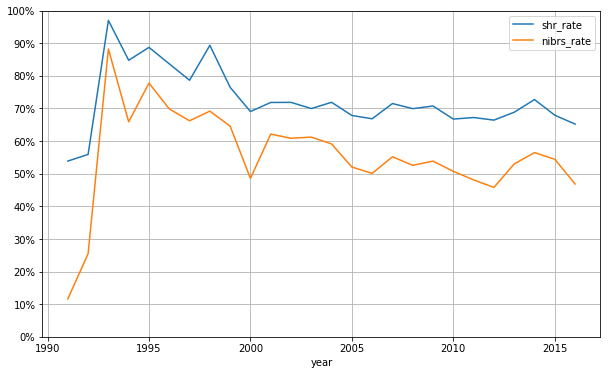

In [41]:
fig, ax = plt.subplots(figsize = (10, 6))

(
    shr_vs_nibrs_by_agency
    .groupby("year")
    .pipe(lambda grp: pd.DataFrame({
        "shr_rate": grp["shr_offender_age_reported"].sum() / grp["shr_offenses"].sum(),
        "nibrs_rate": grp["nibrs_cleared"].sum() / grp["nibrs_offenses"].sum(),
    }))
    .plot(ax = ax)
)
percentify_axes(ax)
ax.grid()
pass

# Racial disparities

Note: When a police department uses NIBRS to submit incident data, it no longer submits Supplementary Homicide Report (SHR) data separately. Instead, the FBI automatically converts the police department's NIBRS data into SHR data. That conversion process, however, does not carry over any ethnicity data. As a result, SHR data for incidents submitted via NIBRS contain no victim ethnicity. For that reason, the comparisons in this section use only the `victim_race` variable, and not `victim_ethnicity`, so that the comparisons are consistent.

(The non-zero percentages for the `in_nibrs` trend below appears to be accounted for by agencies that shifted to NIBRS mid-year.)

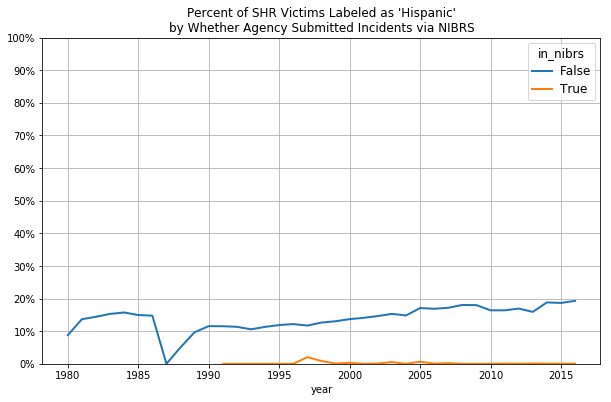

In [42]:
(    
    shr_victims
    .loc[lambda df: df["year"] < 2017]
    .fillna({ "victim_ethnicity": "[blank]" })
    .merge(
        crosswalk,
        on = "agency_ori_7",
        how = "left",
    )
    .groupby([
        "year",
        "agency_ori_9",
        "victim_ethnicity"
    ])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
    .reset_index()
    .merge(
        murder_reporting_years
        [[ "year", "agency_ori_9", "in_nibrs" ]],
        how = "left",
        validate = "1:1"
    )
    .groupby([
        "year",
        "in_nibrs",
    ])
    .sum()
    .assign(prop_h = lambda df: df["H"] / df.sum(axis = 1))
    ["prop_h"]
    .unstack()
    .pipe(
        plot_rates,
        title = (
            "Percent of SHR Victims Labeled as 'Hispanic'\n"
            "by Whether Agency Submitted Incidents via NIBRS"
        )
    )
)
pass

### Count murder victims by race, for each dataset

In [43]:
nibrs_murder_counts_by_race = (
    nibrs_victims
    .loc[lambda df: df["top_offense_code"] == "09A"]
    # Removing the four early non-updating agencies
    .loc[lambda df: ~df["agency_ori_9"].isin(nibrs_early_nonupdaters.index)]
    .groupby([
        "year",
        "agency_ori_9",
        "victim_race"
    ])
    .pipe(lambda grp: pd.DataFrame({
        "nibrs_offenses": grp.size(),
        "nibrs_cleared": grp["clearance_ind"].sum(),
    }))
    .reset_index()
    .merge(
        agency_ori_groups
        [[ "agency_ori_9", "larger_city" ]]
        .dropna(),
        validate = "m:1"
    )
    .loc[lambda df: df["larger_city"] == True]    
)

nibrs_murder_counts_by_race.head()

,year,agency_ori_9,victim_race,nibrs_offenses,nibrs_cleared,larger_city
6,1991,AL0010200,B,124,11,True
7,1991,AL0010200,U,5,0,True
8,1991,AL0010200,W,13,2,True
9,1992,AL0010200,B,68,9,True
10,1992,AL0010200,U,2,0,True


In [44]:
shr_murder_counts_by_race = (
    shr_victims
    .loc[lambda df: df["top_offense_code"] == "09A"]
    .groupby([
        "year",
        "agency_ori_7",
        "victim_race",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "shr_offenses": grp.size(),
        "shr_offender_age_reported": grp["offender_age_reported"].sum(),
    }))
    .reset_index()
    .merge(
        crosswalk
        [[
            "agency_ori_7",
            "agency_ori_9"
        ]],
        how = "left",
        on = [ "agency_ori_7" ]    
    )
    .drop(columns = [ "agency_ori_7" ])
    .merge(
        agency_ori_groups
        [[ "agency_ori_9", "larger_city" ]]
        .dropna(),
        validate = "m:1"
    )
    .loc[lambda df: df["larger_city"] == True]    
)

shr_murder_counts_by_race.head()

,year,victim_race,shr_offenses,shr_offender_age_reported,agency_ori_9,larger_city
0,1980,B,2,2,AK0010100,True
1,1980,I,6,3,AK0010100,True
2,1980,U,1,1,AK0010100,True
3,1980,W,8,6,AK0010100,True
4,1981,B,4,4,AK0010100,True


In [45]:
def calc_disparities(df, source_name):
    return (
        df
        .rename(columns = {
            "shr_offender_age_reported": "numerator",
            "shr_offenses": "denominator",
            "nibrs_cleared": "numerator",
            "nibrs_offenses": "denominator",
        })
        .loc[lambda df: df["victim_race"].isin([ "B", "W" ])]
        .pipe(lambda df: (
            df
            .groupby([
                "year",
                "victim_race"
            ])
            .pipe(lambda grp: pd.DataFrame({
                "num_agencies": grp["agency_ori_9"].nunique(),
                "num_victims": grp["denominator"].sum(),
                "rate": grp["numerator"].sum() / grp["denominator"].sum(),
            }))
            [[ "num_agencies", "num_victims", "rate", ]]
            .unstack()
            .assign(
                diff = lambda df: df[( "rate", "W")] - df[("rate", "B")],
            )
        ))
        .assign(
            source = source_name        
        )
    )

In [46]:
murder_disparities_by_race = (
    pd.concat([
        shr_murder_counts_by_race
        .pipe(calc_disparities, "SHR - All larger-city"),
        
        shr_murder_counts_by_race
        .merge(murder_reporting_years)
        .loc[lambda df: df["in_nibrs"] == True]
        .pipe(calc_disparities, "SHR - NIBRS agency-years"),
        
        shr_murder_counts_by_race
        .merge(murder_reporting_years)
        .loc[lambda df: df["in_nibrs"] == False]
        .pipe(calc_disparities, "SHR - Non-NIBRS agency-years"),
        
        nibrs_murder_counts_by_race
        .pipe(calc_disparities, "NIBRS")
        
    ])
    .sort_values([ "year", "source" ])
)

murder_disparities_by_race.tail(10)

num_agencies      num_victims            rate                diff  \
victim_race            B    W           B     W         B         W             
year                                                                            
2014                 127  162        3031  1819  0.429231  0.636064  0.206832   
2015                  65   78        1372   499  0.494169  0.673347  0.179178   
2015                 194  245        4809  2457  0.474527  0.664225  0.189698   
2015                  66   78        1372   502  0.627551  0.816733  0.189182   
2015                 128  167        3437  1955  0.413442  0.625064  0.211622   
2016                  64   82        1547   638  0.394958  0.633229  0.238271   
2016                 194  252        5325  2828  0.441315  0.631542  0.190227   
2016                  66   85        1545   650  0.587702  0.795385  0.207682   
2016                 128  167        3780  2178  0.381481  0.582645  0.201163   
2017                 188  249        5171  2803  0.467028  0.633964  0.166936   

                                   source  
victim_race                                
year                                       
2014         SHR - Non-NIBRS agency-years  
2015                                NIBRS  
2015                SHR - All larger-city  
2015             SHR - NIBRS agency-years  
2015         SHR - Non-NIBRS agency-years  
2016                                NIBRS  
2016                SHR - All larger-city  
2016             SHR - NIBRS agency-years  
2016         SHR - Non-NIBRS agency-years  
2017                SHR - All larger-city

In [47]:
(
    murder_disparities_by_race
    .loc[2016]
    .sort_values("diff")
    .round(2)
)

num_agencies      num_victims        rate        diff  \
victim_race            B    W           B     W     B     W         
year                                                                
2016                 194  252        5325  2828  0.44  0.63  0.19   
2016                 128  167        3780  2178  0.38  0.58  0.20   
2016                  66   85        1545   650  0.59  0.80  0.21   
2016                  64   82        1547   638  0.39  0.63  0.24   

                                   source  
victim_race                                
year                                       
2016                SHR - All larger-city  
2016         SHR - Non-NIBRS agency-years  
2016             SHR - NIBRS agency-years  
2016                                NIBRS

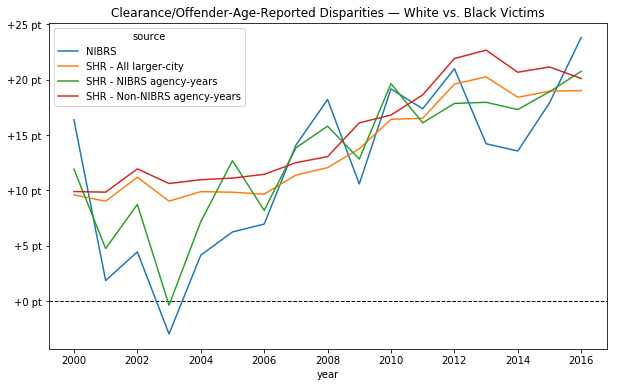

In [48]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.axhline(0, color = "black", linestyle = "--", lw = 1)

(
    murder_disparities_by_race
    .reset_index()
    .set_index([ "year", "source" ])
    ["diff"]
    .unstack()
    .loc[2000:2016]
    .plot(
        ax = ax,
        title = "Clearance/Offender-Age-Reported Disparities — White vs. Black Victims"
    )
)
ax.set_yticklabels([ f"{y * 100:+.0f} pt" for y in ax.get_yticks() ])
pass

---

---

---